# Fault Diagnosis using ProbLog

March 2015  
[Wannes Meert](mailto:wannes.meert@cs.kuleuven.be), DTAI Research Group, KU Leuven

Models for fault diagnosis have been designed as tables (FMECA), trees (FTA) and probabilistic models (BayesNet). Where the tables and trees have the advantage that they allow for natural and complex interactions using logic, they lack in robust dealing with uncertainty. Probabilistic models on the other hand are good candidates to quantify uncertainty but are suboptimal to represent complex, logical interactions. ProbLog offers an intuitive and powerful language to combine both requirements.

Advantages of Probabilstic Logic Languages like ProbLog:

- Lower number of parameters/probabilities because of the expressive logic conditions
- Allowed to express cycles (not supported in FMECA, FTA or BayesNet)
- Type-level expressions (not supported in FMECA, FTA or BayesNet)

*Document setup*: Code blocks starting with `%%script problog-cli.py` are run by piping the rest of the block into the `problog-cli.py` script available in the [ProbLog distribution](https://dtai.cs.kuleuven.be/problog).

In [70]:
from IPython.display import SVG

## Fault Tree Analysis (FTA)

(NASA, 1995) "NASA Preferred Reliability Practices: Fault Tolerant Design", Practice No. PD-ED-1246, JPL, September 21, 1995.

(Bobbio et al., 2001) A. Bobbio, L. Portinale, M. Minichino, and E. Ciancamerla. Improving the analysis of dependable systems by mapping fault trees into bayesian networks. Reliability Engineering and System Safety, 71:249–260, 2001.

(Przytule and Milford, 2006) K. Wojtek Przytula and R. Milford. An efficient framework for the conversion of fault trees to diagnostic bayesian network models. In Aerospace Conference, 2006 IEEE, pages 14–pp. IEEE, 2006.


### Construction of Tree

#### OR Gate

Failure `c` occurs if either failure `a` or `b` occurs (Bobbio et al., 2001, Fig. 1).

In [33]:
%%script problog-cli.py
c :- a.
c :- b.

#### AND Gate

Failure `c` occurs if both failure `a` and `b` occur (Bobbio et al., 2001, Fig. 1).

In [34]:
%%script problog-cli.py
c :- a, b.

#### K:N Gate

Failure `f` occurs if two (K) of the three (N) failures `a`, `b` and `c` occur (Bobbio et al., 2001, Fig. 2).

In [35]:
%%script problog-cli.py
f :- a,b.
f :- a,c.
f :- b,c.

#### Example FTA

Multiprocessor system (Bobbio et al., 2001, Fig. 4).

In [2]:
%%script problog-cli.py
% FTA
fault :- s12.
fault :- n.
s12   :- s1, s2.
s1    :- d(1).
s1    :- m(13).
s1    :- p(1).
s2    :- d(2).
s2    :- m(23).
s2    :- p(2).
d1    :- d(11), d(12).
d2    :- d(21), d(22).
m13   :- m(1),  m(3).
m23   :- m(2),  m(3).
    
% Failure probabilities
% Assume a mission time of 5000 hours
mission_time(5000).
% Define the failure rates of the components (f/h)
failure_rate('processor', 5e-7).
failure_rate('memorybank', 3e-8).
failure_rate('bus', 2e-9).
failure_rate('disk', 8e-5).

P::fails(Component) :-
  mission_time(T),
  failure_rate(Component, FR),
  P is FR*T.

0.5::n.
p(X) :- fails('processor').
d(X) :- fails('disk').
m(X) :- fails('memorybank').
        
% Probability of failure
query(fault).

	fault : 0.70079489


The tree visualized (using Graphviz DOT) looks as follows:

In [81]:
%%script --out graph dot -Tsvg
digraph G {
  graph [resolution=64, fontsize=12];
  s12 -> fault; n -> fault;
  s1 -> s12; s2 -> s12;
  d1 -> s1; m13 -> s1; p1 -> s1;
  d2 -> s2; m23 -> s2; p2 -> s2;
  d11 -> d1; d12 -> d1;
  m1 -> m13; m3 -> m13;
  d21 -> d2; d22 -> d2;
  m2 -> m23; m3 -> m23;
}

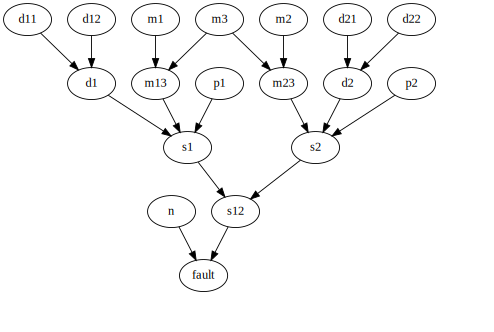

In [82]:
SVG(graph)

#### AND gate with Common Cause Failure (CCF)

AND gate with some common cause failure, or 'leak probability' of 0.01 (Bobbio et al., 2001, Fig. 5).

In [3]:
%%script problog-cli.py
a :- b,c.
0.01::a.

0.5::b. evidence(b,false).
0.5::c. evidence(c,false).
query(a).

	a : 0.01


#### Inhibit gate

Inhibit gate that states that `a` cannot occur if `c` is true, irrespective of `b`.

In [6]:
%%script problog-cli.py
a :- b.
1.0::\+a :- c.

0.5::b. evidence(b,true).
0.5::c. evidence(c,true).
query(a).

	a : 0


#### Any other possible Gate

In fact, you can make any failure propagation probabilistic and dependent on different types of causes:

For example, a **noisy-OR Gate** (with a leak probability):

In [7]:
%%script problog-cli.py
0.9::a :- b.
0.9::a :- c.
0.1::a.

0.5::b. evidence(b,false).
0.5::c. evidence(c,true).
query(a).

	a : 0.91


Another example is a **noisy XOR gate** could be modelled as follows (if either failure `b` or `c` occur the probability of a failure is large but if none or both occur, the probability is low):

In [5]:
%%script problog-cli.py
0.1::a :-   b,  c.
0.9::a :-   b,\+c.
0.9::a :- \+b,  c.
0.1::a :- \+b,\+c.

0.5::b. evidence(b,false).
0.5::c. evidence(c,true).
query(a).

	a : 0.9


## Extensions from Probabilistic Graphical Models

Probabilistic Graphical Models (e.g. Bayesian networks) are a generalization what can be expressed using an FTA. The have become rather popular because efficient algorithms were developed over the past decades that removes a lot of the restrictions present in models such as FTA. For example the restriction that the structure needs to be a tree is not required any more (the complexity for PGMs is now defined by the treewidth of the equivalent tree).

#### Example FTA, extended

Multiprocessor system with power supply (Bobbio et al., 2001, Fig. 6).

The power supply is a multi-valied variables with values `correct`, `defective`, and `failed`.

The power supply influences multiple levels of the FTA, which is not allowed in the FTA formalism but can be expressed in Bayesian networks or ProbLog.

In [4]:
%%script problog-cli.py
% FTA
fault :- s12.
fault :- n.
s12   :- s1, s2.
s1    :- d(1).
s1    :- m(13).
s1    :- p(1).
s2    :- d(2).
s2    :- m(23).
s2    :- p(2).
d1    :- d(11), d(12).
d2    :- d(21), d(22).
m13   :- m(1),  m(3).
m23   :- m(2),  m(3).

% Failure probabilities
% Assume a mission time of 5000 hours
mission_time(5000).
% Define the failure rates of the components (f/h)
failure_rate('processor', 5e-7).
failure_rate('memorybank', 3e-8).
failure_rate('bus', 2e-9).
failure_rate('disk', 8e-5).

P::fails(Component) :-
  mission_time(T),
  failure_rate(Component, FR),
  P is FR*T.

0.5::n.
p(X) :- fails('processor').
ps   :- fails('powersupply').
d(X) :- fails('disk').
m(X) :- fails('memorybank').

% Power supply failure
0.1::fault :- ps(defective).
fault :- ps(failed).

0.1::p(X) :- ps(defective).
p(X) :- ps(failed).

failure_rate('powersupply', 8e-5).
ps(failed) :- fails('powersupply').
ps(defective) :- fails('powersupply').
        
% Probability of failure
query(fault).

	fault : 0.82047693


When we visualize this 'FTA', you can see that there are now connections that span multiple levels. As a result this is a graph and not a tree. Traditional FTA techniques cannot handle graphs, fortunately probabilistic graphical models can and ProbLog computes a result in a fraction of a second.

In [84]:
%%script --out graph dot -Tsvg
digraph G {
  graph [resolution=64, fontsize=12];
  s12 -> fault; n -> fault; ps -> fault;
  ps -> p1; ps -> p2;
  s1 -> s12; s2 -> s12;
  d1 -> s1; m13 -> s1; p1 -> s1;
  d2 -> s2; m23 -> s2; p2 -> s2;
  d11 -> d1; d12 -> d1;
  m1 -> m13; m3 -> m13;
  d21 -> d2; d22 -> d2;
  m2 -> m23; m3 -> m23;
}

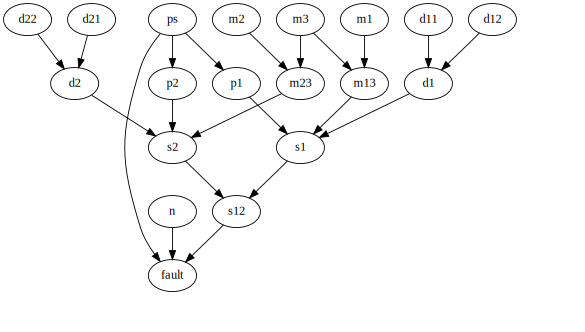

In [85]:
SVG(graph)

### Multi-valued nodes

PGMs allow for multi-valued nodes. For example a failure mode can be `high`, `low`, `none`:

In [2]:
%%script problog-cli.py
0.90::status(none) ; 0.09::status(low) ; 0.01::status(high).
0.10::status(none) ; 0.80::status(low) ; 0.10::status(high) :- ccf1.
0.05::status(none) ; 0.10::status(low) ; 0.85::status(high) :- ccf2.

0.10::ccf1.
0.01::ccf2.

query(status(none)).
query(status(low)).
query(status(high)).

	status(high) : 0.02823085
	 status(low) : 0.1636372
	status(none) : 0.9010495


## Extensions from Probabilistic Logics

Probabilistic logics (part of the field of probabilistic programming) provide a more rich modelling language and are able to exploit event more structure in the model than PGMs did. Especially for domains with a lot of deterministic or functional knowledge in the model, this can result in a significant decrease of runtime and allows for much more complex models.

Therefore, a probabilistic logic allows for more complex statemens such as:

- Both logic structure and quantitative uncertainty.
- General rules over groups of objects (e.g., `d(X) :- fails('disk')` to express that all disks have the same failure probability).
- Cycles are allowed (e.g., `fail(comp1) :- fail(comp2). fail(comp2) :- fail(comp1).`).

#### Complex failure formulas

The probability of failure is here defined using a simple formula: `failure_rate * time`. If a more complicated distribution is required, this can be computed using Python and the `call_external/1` predicate that ProbLog offers. We can add the following Python definitions to a file called `fails.py` to be used as part of ProbLog.

For example, we can use standard FTA failure rate formulas like:

In [ ]:
import math

def fails_nonrepairable(lam, t):
    """Failure probability for a non-repairable component
       lam: component failure time
       t: exposure time
    """
    return 1-math.exp(-lam*t)

def fails_repairable(lam, tau):
    """Failure probability for a repairable component
       lam: component failure rate
       t: repair time
    """
    return lam*tau/(1+lam*tau)
    

Or we can use Scipy for a wide range of distributions such as Weibull:

In [86]:
def fails_weibull(k, mu, lam, t):
  import scipy
  dist = scipy.stats.dweibull(k, mu, lam)
  return dist.pdf(t)

In [89]:
%%script problog-cli.py
:- load_external('fails.py').

P::fails(Component) :-
  k(K), mu(MU), lam(LAM), mission_time(T),
  call_external(fails_weibull(K, MU, LAM, T), P).

### Cut set analysis

[Wikipedia](http://en.wikipedia.org/wiki/Fault_tree_analysis):

>The route through a tree between an event and an initiator in the tree is called a Cut Set. The shortest credible way through the tree from fault to initiating event is called a Minimal Cut Set.

Since ProbLog still expresses the logic interactions explicitely, one can apply cut set analysis on a ProbLog program. This can be achieved by using ProbLog's built-in translation to a CNF and apply an SMT solver for minimal cut sets. See for example the approach followed in the [Haskell Fault Tree Analysis library](https://github.com/tomahawkins/fault-tree).

## Failure Mode and Effect Analysis (FMEA)

(Quality Digest, 2005) Quality Digest, [Failure Mode and Effect Analysis -- A Tutorial](http://www.qualitydigest.com/inside/six-sigma-article/failure-mode-and-effect-analysis-tutorial), 2005.

An FMEA is a summarization of what the causes and effects are of a failure in the system. It is a table with as columns item, function, failure, effect, SOD, and cause. Every row in the table expresses a failure of a certain system, subsystem or component.

<table>
	<tbody><tr><th>Item</th><th>Function</th><th>Failure</th><th>Effect</th><th>SOD</th><th>Cause
	</th></tr><tr>
		<td>The name of the system, subsystem, subsubsystem, ..., or component.
		</td><td>A function the item is supposed to perform.
		</td><td>The failure mode.
		</td><td>A set of effects of the failure.
		</td><td>Probability indicating Severity, Occurence and Dectection.
		</td><td>A cause is a formula made from failures from a lower level, noise, design parameters, conjunctions, disjunctions and negations.
</td></tr></tbody></table>

### Translation to ProbLog

<table>
	<tbody><tr><th>FM</th><th>Cause</th><th>Effect</th><th>Component</th><th>SOD
	</th></tr><tr>
		<td>fm1
		</td><td>event(cause1) OR (event(cause2, comp2) AND event(cause3, comp3))
		</td><td>event(effect1, comp1) AND event(effect2, comp1)
		</td><td>comp1
		</td><td>0.999
</td></tr></tbody></table>

In [ ]:
%%script problog-cli.py

or1 :- event(cause1, comp2).
or1 :- event(cause2, comp2) , event(cause3,comp3).
failuremode(fm, func1):0.999 :- or1.

event(effect1, comp1) :- failuremode(fm, func1).
event(effect2, comp1) :- failuremode(fm, func1).

## More information

[https://dtai.cs.kuleuven.be/problog](https://dtai.cs.kuleuven.be/problog)

Copyright 2015, KU Leuven, [DTAI Research Group](https://dtai.cs.kuleuven.be)